In [29]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import h5py
import numpy as np
from tqdm.notebook import tqdm
from utils import get_outputs_labels, get_correct_idxs, get_incorrect_idxs, propci_wilson_cc
import matplotlib.pyplot as plt

# How many corruptions per dataset/model combination
datasets = ['imnet', 'flowers102']
models = ['inceptionv3', 'resnet18', 'MobileNetV2', 'resnet50',]
aggs = ['mean', 'partial_lr', 'full_lr', 'ours', 'gps']
tta_policies = ['five_crop_hflip_scale']
#orig_idx = 50
#tta_policy = 'pil'
orig_idx = 12


model_name_dict = {'resnet18': 'ResNet-18', 'resnet50': 'ResNet-50', 
                   'MobileNetV2': 'MobileNetV2', 'inceptionv3': 'InceptionV3',
                  }
dataset_name_dict = {'imnet': 'ImageNet', 'flowers102': 'Flowers-102', 'birds200': 'Birds200'}
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
results = []
tta_policy = 'pil'
for tta_policy in tta_policies:
    for agg in tqdm(aggs):
        for dataset in datasets:
            for model in tqdm(models):
                orig_path = '../' + dataset + '/' + tta_policy + '/aggregated_outputs/val/' + model + '/orig/mean.h5'
                hf = h5py.File(orig_path, 'r')
                orig_preds = hf['batch1_outputs'][:]
                orig_labels = hf['batch1_labels'][:]

                stta_path = '../' + dataset + '/' + tta_policy + '/aggregated_outputs/val/' + model + '/combo/' + agg + '.h5'
                hf = h5py.File(stta_path, 'r')
                stta_preds = hf['batch1_outputs'][:]
                stta_labels = hf['batch1_labels'][:]
                stta_correct_idxs = get_correct_idxs(stta_preds, stta_labels)
                stta_incorrect_idxs = get_incorrect_idxs(stta_preds, stta_labels)
                orig_correct_idxs = get_correct_idxs(orig_preds, orig_labels)
                orig_incorrect_idxs = get_incorrect_idxs(orig_preds, orig_labels)
                corruptions = set(stta_incorrect_idxs).intersection(orig_correct_idxs)
                corrections = set(stta_correct_idxs).intersection(orig_incorrect_idxs)
                results.append({'dataset': dataset, 'model': model, 'agg': agg,
                                'n_changed': len(corruptions), 'change_type': 'Corruptions'})
                results.append({'dataset': dataset, 'model': model, 'agg': agg,
                                'n_changed': len(corrections), 'change_type': 'Corrections'})
results_df = pd.DataFrame(results)
results_df.to_csv('../results/' + tta_policy + '_corruptions_corrections')

In [31]:
results_df = pd.read_csv('../results/' + tta_policy + '_corruptions_corrections')
corruptions = results_df[results_df['change_type'] == 'Corruptions'][['dataset', 'model', 'n_changed', 'agg']]
corruptions = corruptions[corruptions['agg'].isin(['mean', 'ours', 'partial_lr', 'gps'])]

In [32]:
corruptions.groupby(['dataset', 'model', 'agg']).mean()

n_changed
dataset    model       agg                  
flowers102 MobileNetV2 gps               117
                       mean               38
                       ours               25
                       partial_lr         19
           inceptionv3 gps                49
                       mean               25
                       ours               43
                       partial_lr         29
           resnet18    gps                39
                       mean               36
                       ours               55
                       partial_lr         24
           resnet50    gps                21
                       mean               21
                       ours               17
                       partial_lr         17
imnet      MobileNetV2 gps               550
                       mean              563
                       ours              918
                       partial_lr        502
           inceptionv3 gps               655
                       mean              544
                       ours              865
                       partial_lr        637
           resnet18    gps               676
                       mean              599
                       ours              554
                       partial_lr        554
           resnet50    gps               317
                       mean              489
                       ours              415
                       partial_lr        415

In [100]:
results_df = pd.read_csv('../results/' + agg + '_corruptions_corrections')
for dataset in datasets:
    for model in models:
        exists = results_df[(results_df['model'] == model) & 
                                 (results_df['dataset'] == dataset) &
                             (results_df['change_type'] == 'Net')]
        if len(exists):
            continue
            
        if dataset == 'imnet':
            n_total = 50000
        else:
            n_total = 6149
        n_corrupted = results_df[(results_df['model'] == model) & 
                                 (results_df['dataset'] == dataset) &
                               (results_df['change_type'] == 'Corruptions')]['n_changed']
        n_corrupted = list(n_corrupted)[0]
        n_corrected = results_df[(results_df['model'] == model) & 
                                 (results_df['dataset'] == dataset) &
                               (results_df['change_type'] == 'Corrections')]['n_changed']
        n_corrected = list(n_corrected)[0]
        n_changed = n_corrected - n_corrupted

        pct_changed = n_changed/n_total
        ci_l, ci_u = propci_wilson_cc(n_changed, n_total)

        results_df = results_df.append({'dataset': dataset, 'n_changed': n_changed, 'change_type': 'Net',
                                'pct_changed':pct_changed,
                                'model': model, 'error': ci_u - ci_l}, ignore_index=True)
results_df.to_csv('../results/' + agg + '_corruptions_corrections')

In [2]:
def grouped_barplot(df, cat,subcat, val , err, ax):
    plt.sca(ax)
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = df[subcat].unique()
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width= np.diff(offsets).mean()
    print(ax)
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.bar(x+offsets[i], dfg[val].values, width=width,
                label="{}".format(gr), yerr=dfg[err].values)
    plt.xlabel(cat)
    plt.ylabel(val)
    plt.xticks(x, u)
    #plt.legend()
    #plt.show()

AxesSubplot(0.125,0.125;0.352273x0.755)
AxesSubplot(0.547727,0.125;0.352273x0.755)


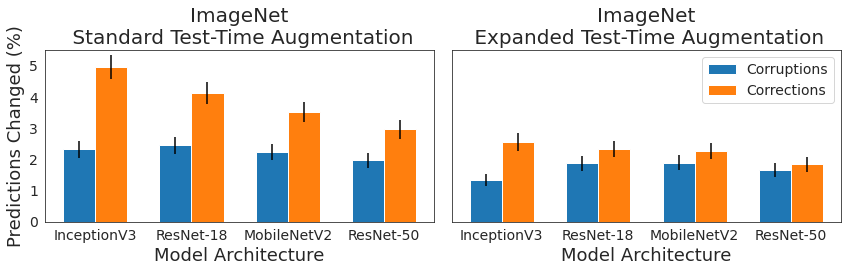

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
datasets = ['imnet', 'flowers102']
models = ['inceptionv3', 'resnet18', 'MobileNetV2', 'resnet50',]
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for i in range(2,4):
    dataset = 'imnet'
    path = '../results/expanded_corruptions_corrections'
    ax = axs[i-2]
    if i < 2:
        dataset = 'flowers102'
    if i % 2 == 0:
        path = '../results/corruptions_corrections'
    results_df = pd.read_csv(path)
    ds_results = results_df[results_df['dataset'] == dataset]
    ds_results = ds_results[ds_results['change_type'].isin(['Corruptions', 'Corrections'])]
    if dataset == 'imnet':
        n_samples = 50000
    elif dataset == 'flowers102':
        ax.set_ylim(0, .0175)
        n_samples = 6149
        
    #ax.set_ylim(0, .055)
    ax.set_ylim(0, 5.5)
    ds_results['pct_changed'] = ds_results['n_changed']/n_samples
    ds_results['ci_l'] = ds_results.apply(lambda row: propci_wilson_cc(row.n_changed, n_samples)[0],
                                          axis=1)
    ds_results['ci_u'] = ds_results.apply(lambda row: propci_wilson_cc(row.n_changed, n_samples)[1],
                                              axis=1)
    ds_results['error'] = ds_results['ci_u'] - ds_results['ci_l']    
    
    ds_results['error_scaled'] = 100*ds_results['error']
    ds_results['pct_changed_scaled'] = 100*ds_results['pct_changed']
    cat = 'model'
    subcat = 'change_type'
    err = 'error_scaled'
    val = 'pct_changed_scaled'
    grouped_barplot(ds_results, cat, subcat, val, err, ax)
    
    
    
    
    ax.set_ylabel("Predictions Changed (%)")
    if i % 2 == 1:
        ax.set_yticklabels([])
        ax.set_ylabel("")

    ax.set_xlabel("Model Architecture")
    ax.set_xticklabels([model_name_dict[i] for i in models])
    if i % 2 == 0:
        ax.set_title(dataset_name_dict[dataset] + "\n Standard Test-Time Augmentation")
    else:
        ax.set_title(dataset_name_dict[dataset] + "\n Expanded Test-Time Augmentation")
    if i % 2 == 1:
        plt.legend()
plt.tight_layout()

/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

AxesSubplot(0.125,0.125;0.775x0.755)


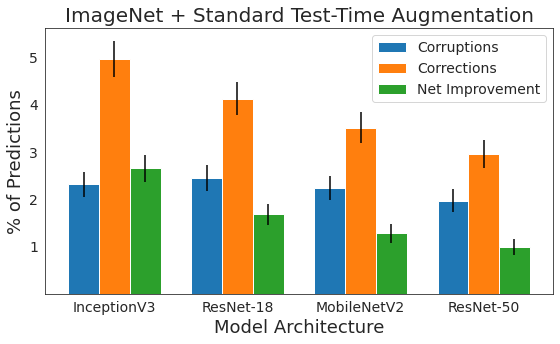

In [4]:
dataset = 'imnet'
path = '../results/corruptions_corrections'
results_df = pd.read_csv(path)
ds_results = results_df[results_df['dataset'] == dataset]
n_samples = 50000
fig, ax = plt.subplots(1, figsize=(8, 5))
ds_results['pct_changed'] = ds_results['n_changed']/n_samples
ds_results['ci_l'] = ds_results.apply(lambda row: propci_wilson_cc(row.n_changed, n_samples)[0],
                                          axis=1)
ds_results['ci_u'] = ds_results.apply(lambda row: propci_wilson_cc(row.n_changed, n_samples)[1],
                                          axis=1)
ds_results['error'] = ds_results['ci_u'] - ds_results['ci_l']    

for model in models:
    n_corrupted = ds_results[(ds_results['model'] == model) & 
                           (ds_results['change_type'] == 'Corruptions')]['n_changed']
    n_corrupted = list(n_corrupted)[0]
    n_corrected = ds_results[(ds_results['model'] == model) & 
                           (ds_results['change_type'] == 'Corrections')]['n_changed']
    n_corrected = list(n_corrected)[0]
    n_changed = n_corrected - n_corrupted
    pct_changed = n_changed/50000
    ci_l, ci_u = propci_wilson_cc(n_changed, 50000)
    
cat = 'model'
subcat = 'change_type'
err = 'error'
val = 'pct_changed'
grouped_barplot(ds_results, cat, subcat, val, err, ax)
ax.set_ylabel("% of Predictions")

ax.set_xlabel("Model Architecture")
ax.set_xticklabels([model_name_dict[i] for i in models])
ax.set_title(dataset_name_dict[dataset] + " + Standard Test-Time Augmentation")
L = plt.legend()
L.get_texts()[2].set_text('Net Improvement')
#plt.yticks(tick_vals, new_tick_labels)
ax.set_yticklabels(['', '1', '2', '3', '4', '5'])
plt.tight_layout()


In [33]:
tick_labels

[Text(0, 0.0, '0.00'),
 Text(0, 0.01, '0.01'),
 Text(0, 0.02, '0.02'),
 Text(0, 0.03, '0.03'),
 Text(0, 0.04, '0.04'),
 Text(0, 0.05, '0.05'),
 Text(0, 0.06, '0.06')]

In [22]:
[str(100*float(tick_labels[i].get_text())) for i in range(6)]

['0.0', '1.0', '2.0', '3.0', '4.0', '5.0']

In [106]:
# Relationship between model size and accuracy
# x axis = model size y axis = average agreement of augmentations with one another
# do this for standard + flowers, standard + imnet, expanded + flowers, expanded + imnet
model_params_map = {'resnet18': 11000000, 'resnet50': 23000000, 'MobileNetV2': 3400000,
                   'inceptionv3': 23885392}
model_results = []
datasets=['flowers102']
tta_policy = 'five_crop_hflip_scale'
orig_idx = 12
for dataset in datasets:
    if dataset == 'imnet':
        n_samples = 50000
    else:
        n_samples = 6149
    ds_results = results_df[results_df['dataset'] == dataset]
    for model in tqdm(models):
        path = '../' + dataset + '/' + tta_policy + '/model_outputs/val/' + model + '.h5'
        outputs, labels = get_outputs_labels(path)
        print("loaded output labels")
        
        stta_preds = np.mean(outputs, axis=0)
        orig_preds = outputs[orig_idx,:,:]
        orig_correct_idxs = get_correct_idxs(orig_preds, labels)
        orig_acc = len(orig_correct_idxs)/len(labels)
        n_improved = ds_results[(ds_results['model'] == model) & 
                                (ds_results['dataset'] == dataset) & 
                                (ds_results['change_type'] == 'Net')]['n_changed']
        n_improved = list(n_improved)[0]
        tta_gain = n_improved/n_samples
        # iterate over all augmentations
        n_augs = len(outputs)
        idxs = np.arange(n_augs)
        for aug_idx in tqdm(range(n_augs)):
            aug_preds = outputs[aug_idx]
            orig_preds = outputs[orig_idx]
            aug_labels = np.argmax(aug_preds, axis=1)
            orig_labels = np.argmax(orig_preds, axis=1)
            n_agree = len(np.where(aug_labels == orig_labels)[0])
            agreement = n_agree/len(aug_labels)  
            gen_error = len(get_correct_idxs(aug_preds, labels))/len(labels)
            model_results.append({'model': model, 'dataset': dataset, 'orig_acc': orig_acc, 
                            'agreement': agreement, 'tta_gain': tta_gain,
                             'gen_error': gen_error, 'aug_idx': aug_idx})
models_df = pd.DataFrame(model_results)
models_df.to_csv(''.join(datasets) + '_agreement_results')
#models_df.to_csv('flowers102_standard_model_results')

loaded output labels



loaded output labels



loaded output labels



loaded output labels


In [107]:
models_df['model_no'] = models_df['model'].map({'inceptionv3': 0, 'resnet18': 1, 
                                                'MobileNetV2': 2, 'resnet50': 3})

Text(0.5, 1.0, 'Augmentation Agreement over Models')

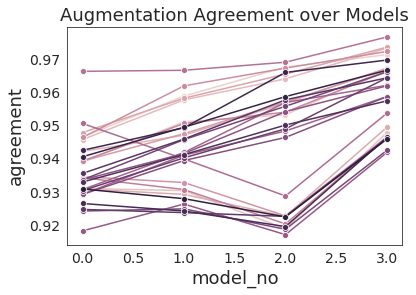

In [108]:
no_original = models_df[models_df['aug_idx'] != orig_idx]
ax = sns.lineplot(x='model_no', y='agreement', hue='aug_idx', data=no_original, marker='o')
ax.get_legend().remove()
plt.title("Augmentation Agreement over Models")

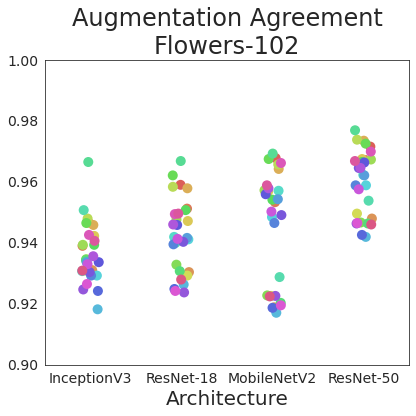

In [15]:
SMALL_SIZE = 14
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#models_df = pd.read_csv('imnetflowers102_agreement_results')
models_df = pd.read_csv('flowers102_agreement_results')

model_order = ['inceptionv3', 'resnet18', 'MobileNetV2', 'resnet50']
plt.figure(figsize=(6, 6))
no_original = models_df[models_df['aug_idx'] != orig_idx]
sns.set_palette(sns.color_palette("hls", 30))
ax = sns.stripplot(x='model', y='agreement', hue='aug_idx', data=no_original, 
                   order=model_order, size=10)
ax.get_legend().remove()

# remove idx 12 
# add titel
plt.xlabel("Architecture")

plt.ylabel("Aug. Agreement")

# plt.title("Augmentation Agreement\nImageNet")
# plt.ylim(.7, 1)

plt.title("Augmentation Agreement\nFlowers-102")
plt.ylabel("")
plt.ylim(.9, 1)

plt.xticks(list(range(4)), [model_name_dict[m] for m in model_order])
# what augmentations are in that tiny bubble that's lower for MobileNetV2?
plt.tight_layout()
#plt.legend()


In [147]:
import sys
def invert_aug_list(aug_list, aug_order):
    def parse_five_crop(num):
        num_map = {0:'center crop', 1: 'upper left crop', 2: 'upper right crop', 3: 'lower left crop',
                   4: 'lower right', 5: 'uncropped original'}
        return num_map[num]
    def parse_flip(num):
        num_map = {0: 'no hflip', 1: 'hflip'}
        return num_map[num]
    def parse_scale(num):
        return str(num*100)[:3] + "% zoomed in"

    inv_parse_fs = {'modified_five_crop': parse_five_crop, 'hflip': parse_flip, 'scale': parse_scale,
                    'five_crop': parse_five_crop}

    all_descriptions = []
    for aug_nums in aug_list:
        
        descriptions = [inv_parse_fs[aug](aug_nums[i]) for i,aug in enumerate(aug_order)]
        descriptions = ','.join(descriptions)
        all_descriptions.append(descriptions)
    return all_descriptions
aug_list = np.load('../' + 'flowers102' + '/' + 'five_crop_hflip_scale' + '/aug_list.npy')
aug_order = np.load('../' +'flowers102' + '/' + 'five_crop_hflip_scale' + '/aug_order.npy')
aug_names = invert_aug_list(aug_list, aug_order)
aug_idxs = list(models_df[(models_df['model'] == 'MobileNetV2') & (models_df['agreement'] < .93)]['aug_idx'])
[aug_names[i] for i in aug_idxs]

['no hflip,upper left crop,10.% zoomed in',
 'no hflip,lower left crop,10.% zoomed in',
 'no hflip,lower right,10.% zoomed in',
 'no hflip,upper right crop,10.% zoomed in',
 'no hflip,center crop,10.% zoomed in',
 'hflip,upper left crop,10.% zoomed in',
 'hflip,lower left crop,10.% zoomed in',
 'hflip,lower right,10.% zoomed in',
 'hflip,upper right crop,10.% zoomed in',
 'hflip,center crop,10.% zoomed in']

In [ ]:
model_order = ['inceptionv3', 'resnet18', 'resnet50', 'MobileNetv2']
ax = sns.stripplot(x='model_no', y='agreement', hue='aug_idx', data=models_df)
plt.ylim(.7, 1)
ax.get_legend().remove()

# remove idx 12 
# add titel
plt.ylabel("Augmentation Agreement")
plt.title("Augmentation Agreement for Different Models")
# what augmentations are in that tiny bubble that's lower for MobileNetV2?
plt.tight_layout()


In [42]:
set(models_df['model'])

{'MobileNetV2', 'inceptionv3', 'resnet18', 'resnet50'}

In [12]:
import seaborn as sns
sns.set_style('white')
df1 = pd.read_csv('flowers102_standard_model_results')
df2 = pd.read_csv('standard_model_results')
models_df = pd.concat([df2[df2['dataset'] == 'imnet'], df1])
dataset = 'imnet'
ds_models_df = models_df[models_df['dataset'] == dataset]
ds_models_df["id"] = ds_models_df.index + 1


/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


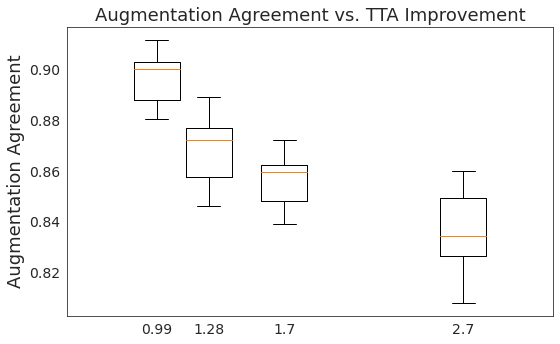

In [17]:
imnet_p = [0.01276, 0.02652, 0.01682, 0.00988]
imnet_p = [1.28, 2.7, 1.7, 0.99]

flowers102_p = [-0.49, 7.2, 3.6, 0.0, ]
flowers102_p_labels = ["-0.05", "0.72","0.36", "0.0"]
if dataset == 'flowers102':
    p = flowers102_p
else:
    p = imnet_p
    
plt.figure(figsize=(8, 5))
agreement = ds_models_df.pivot(index='model',columns='aug_idx',values='ambiguity')
if dataset == 'flowers102':
    plt.boxplot(agreement.values.T, positions=p, widths=(.4, .4, .4, .4))
    plt.xticks(sorted(flowers102_p), ["-0.05", "0","0.36", "0.72"] )
else:
     plt.boxplot(agreement.values.T, positions=p)
plt.ylabel("Augmentation Agreement")
plt.xlabel("TTA Increase in Accuracy (%)  ")
plt.xlabel("")
plt.title("Augmentation Agreement vs. TTA Improvement")
plt.tight_layout()

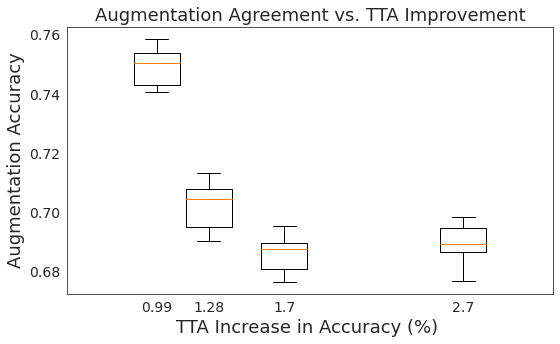

In [16]:
imnet_p = [0.01276, 0.02652, 0.01682, 0.00988]
imnet_p = [1.28, 2.7, 1.7, 0.99]

flowers102_p = [-0.49, 7.2, 3.6, 0.0]
flowers102_p = [-0.49, 7.2, 3.6, 0.0, ]
flowers102_p_labels = ["-0.05", "0.72","0.36", "0.0"]
if dataset == 'flowers102':
    p = flowers102_p
else:
    p = imnet_p
    
flowers102_p_labels = [-0.049, 0.72,0.36, 0.0, ]
plt.figure(figsize=(8, 5))
agreement = ds_models_df.pivot(index='model',columns='aug_idx',values='gen_error')
if dataset == 'flowers102':
    plt.boxplot(agreement.values.T, positions=p, widths=(.4, .4, .4, .4))
    plt.xticks(sorted(flowers102_p), ["-0.05", "0","0.36", "0.72"] )
else:
     plt.boxplot(agreement.values.T, positions=p)
plt.ylabel("Augmentation Accuracy")
plt.xlabel("TTA Increase in Accuracy (%) ")
plt.title("Augmentation Agreement vs. TTA Improvement")
plt.tight_layout()

In [112]:
ds_models_df[ds_models_df['model'] == 'MobileNetV2']

,model,dataset,orig_acc,ambiguity,tta_gain,gen_error,aug_idx,id
60,MobileNetV2,flowers102,0.906001,0.959180,0.01276,0.908115,0,61
61,MobileNetV2,flowers102,0.906001,0.966824,0.01276,0.903074,1,62
62,MobileNetV2,flowers102,0.906001,0.940803,0.01276,0.879330,2,63
63,MobileNetV2,flowers102,0.906001,0.956904,0.01276,0.906001,3,64
64,MobileNetV2,flowers102,0.906001,0.966336,0.01276,0.904212,4,65
65,MobileNetV2,flowers102,0.906001,0.943568,0.01276,0.884046,5,66
66,MobileNetV2,flowers102,0.906001,0.959180,0.01276,0.905350,6,67
67,MobileNetV2,flowers102,0.906001,0.965685,0.01276,0.904049,7,68
68,MobileNetV2,flowers102,0.906001,0.944706,0.01276,0.880631,8,69
69,MobileNetV2,flowers102,0.906001,0.958367,0.01276,0.907302,9,70


/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'Gain in % Accuracy from Test-Time Augmentation')

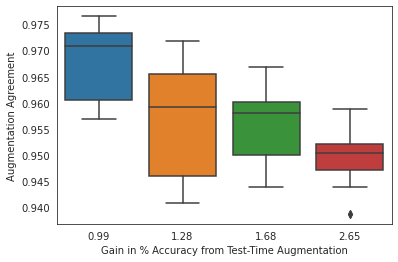

In [76]:
# Violin plot of generalization errors as model accuracy goes up?
# Generalization vs. Test-Time Augmentation Improvement
sns.boxplot(x='tta_gain_num', y='ambiguity', data=ds_models_df, order=[.99, 1.28, 1.68, 2.65])
plt.ylabel("Augmentation Agreement")
plt.xlabel("Gain in % Accuracy from Test-Time Augmentation")

/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 0, '% Gain from Test-Time Augmentation')

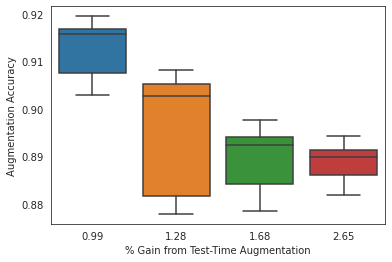

In [73]:
#ds_models_df['tta_gain_cat'] = ds_models_df['tta_gain'].astype('category')
ds_models_df['tta_gain_num'] = ds_models_df.apply(lambda row: round(100*list(list(row['tta_gain']))[0], 2), axis=1)

sns.boxplot(x='tta_gain_num', y='gen_error', data=ds_models_df)
plt.ylabel("Augmentation Accuracy")
plt.xlabel("% Gain from Test-Time Augmentation")

# Dataset size vs. TTA gain

In [2]:
# iterate over different models
# record original accuracy, tta accuracy, tta_gain for each model
# record dataset size
# sns plot x = dataset size, y = tta_gain
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
pct_opts = ['0.1', '0.15', '0.2', '0.25', '0.3', '0.35', '0.4', '0.45', 
            '0.5', '0.55','0.6', '0.65', '0.7', '0.75', '0.8', '0.9',  '1.0']

# pct_opts = ['0.1', '0.2', '0.3', '0.4', 
#             '0.5', '0.6',  '0.7','0.8', '0.9',  '1.0']
pct_opts = ['0.1', '0.2', '0.3', 
            '0.5',   '0.7', '0.9',]

# pct_opts = ['0.1', '0.2', '0.3', '0.4', 
#             '0.5', '0.6',  '0.7','0.8', '0.9']
results = []
for pct_opt in pct_opts:
    model_name = 'resnet50_added_data_' + pct_opt
    results_path = model_name + '_agg_fs'
    df = pd.read_csv('../results/flowers102/five_crop_hflip_scale/val/' + results_path)
    orig_vals = list(df[df['aug']  == 'orig']['top1'])
    stta_vals = list(df[(df['aug'] == 'combo') &
                        (df['agg'] == 'mean')]['top1'])
    for i in range(len(orig_vals)):
        tta_gain = stta_vals[i] - orig_vals[i] 
        results.append({'dataset_size': 100*float(pct_opt), 'tta_gain': tta_gain, 
                        'orig': orig_vals[i]})

results_df = pd.DataFrame(results)
    

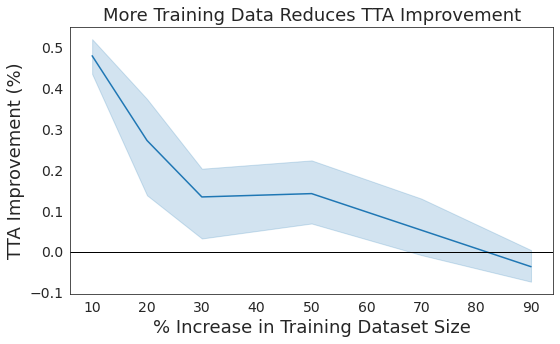

In [16]:

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

sns.set_style('white')
plt.figure(figsize=(8, 5))
results_df['tta_gain_scaled'] = 100*results_df['tta_gain']
ax = sns.lineplot(x='dataset_size', y='tta_gain', data=results_df)
plt.ylabel("TTA Improvement (%)")
plt.xlabel("% Increase in Training Dataset Size")
plt.title("More Training Data Reduces TTA Improvement")
ax.axhline(y=0, c='black', lw=1)
plt.tight_layout()

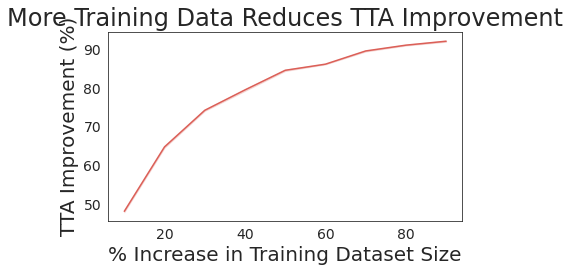

In [23]:
sns.set_style('white')
plt.figure(figsize=(6, 4))
sns.lineplot(x='dataset_size', y='orig', data=results_df)
plt.ylabel("TTA Improvement (%)")
plt.xlabel("% Increase in Training Dataset Size")
plt.title("More Training Data Reduces TTA Improvement")
plt.tight_layout()

In [20]:
# 1000 examples
# 1500 examples
# 2000 examples
# 2500 examples
# 3000 examples
# 6, 7, 8, 9, 10 images per class 
# 
results_df

,dataset_size,tta_gain
0,10.0,-0.508131
1,10.0,-0.081301
2,10.0,-0.060976
3,10.0,0.284554
4,10.0,0.223576
5,20.0,1.056911
6,20.0,0.711380
7,20.0,0.873978
8,20.0,1.321136
9,20.0,0.345531
